# Predicting Hypoglycemic Events in Diabetic Patients



## 1. Problem Statement

### 1.1 Medical Context

**Diabetes mellitus** is a chronic pathology characterized by impaired blood glucose 
regulation. Insulin-dependent patients (Type 1 and some Type 2) must frequently monitor 
their blood glucose and self-administer exogenous insulin.

One of the most insidious risks in insulin therapy is **hypoglycemia**: a drop in blood 
glucose below normal values (typically < 70 mg/dL). It can cause:

- Sweating, tremors, and confusion (blood glucose between 40–80 mg/dL)
- Loss of consciousness and seizures in severe cases (below 40 mg/dL)
- Fatal consequences if not promptly treated

### 1.2 Research Question

> **Is it possible to predict a future hypoglycemic event from recent glucose 
> measurements, insulin doses, and behavioral patterns (meals, physical activity)?**

### 1.3 ML Model Objective

Build a **binary classification** model that, given the last N glucose measurements of 
a patient along with contextual information (insulin, meals, exercise), predicts whether 
a hypoglycemic event will occur in the near future.

**Model Output:** `1` = hypoglycemic event predicted, `0` = no event

**Clinical Utility:** A predictive alert could allow the patient (or physician) to 
intervene preventively — for example, by ingesting carbohydrates or reducing the 
next insulin dose.

> **Note on evaluation:** In a clinical setting, missing a real hypoglycemic event 
> (false negative) is more dangerous than triggering a false alarm (false positive). 
> This asymmetry will guide our choice of evaluation metrics throughout the project.

---
## 2. Setup – Importing Libraries

In [1]:
# !pip install pandas numpy scikit-learn matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-whitegrid')

## 3. Dataset Loading and Description

### 3.1 Dataset Structure

The dataset comes from the **UCI Machine Learning Repository – Diabetes Dataset**.
It contains records from **70 diabetic patients** collected over several weeks or months 
in an outpatient setting.

Each record has 4 fields:

| Field | Description                              |
|-------|------------------------------------------|
| Date  | MM-DD-YYYY                               |
| Time  | HH:MM                                    |
| Code  | Event type (see table below)             |
| Value | Numerical value associated with the event|

**Relevant event codes:**

| Code(s)  | Meaning                                          |
|----------|--------------------------------------------------|
| 33, 34, 35 | Insulin doses (Regular, NPH, UltraLente)       |
| 48, 57–64  | Blood glucose measurements (various meal times)|
| 65         | Hypoglycemic symptoms                          |
| 66–68      | Meal size (typical / large / light)            |
| 69–71      | Physical activity (typical / intense / light)  |

### 3.2 A Note on Data Sparsity

Unlike modern continuous glucose monitors (CGM), this dataset contains only 
**sporadic measurements** taken a few times per day.

| Statistic         | Value          |
|-------------------|----------------|
| Mean gap between measurements  | ~7.0 hours |
| Median gap between measurements| ~5.7 hours |
| Gaps longer than 6 hours       | ~5,500 total |

This sparsity has a direct consequence on the modeling strategy: instead of working 
with fixed-duration time windows (e.g., "the last 3 hours"), we work with the 
**last N glucose measurements**, regardless of how much time has elapsed between them. 
This makes the approach more robust to the irregular sampling of the data.

In [2]:
CODE_DESCRIPTIONS = {
    33: 'Regular insulin dose',
    34: 'NPH insulin dose',
    35: 'UltraLente insulin dose',
    48: 'Blood glucose (unspecified)',
    57: 'Blood glucose (unspecified)',
    58: 'Pre-breakfast BG',
    59: 'Post-breakfast BG',
    60: 'Pre-lunch BG',
    61: 'Post-lunch BG',
    62: 'Pre-supper BG',
    63: 'Post-supper BG',
    64: 'Pre-snack BG',
    65: 'HYPOGLYCEMIC SYMPTOMS',
    66: 'Typical meal',
    67: 'More-than-usual meal',
    68: 'Less-than-usual meal',
    69: 'Typical exercise',
    70: 'More-than-usual exercise',
    71: 'Less-than-usual exercise',
    72: 'Unspecified special event'
}

# Codes representing glucose measurements
BG_CODES = [48, 57, 58, 59, 60, 61, 62, 63, 64]

def load_diabetes_data(data_folder='data'):
    """
    Load all the files of UCI Diabetes dataset.
    """
    files = sorted(glob(f'{data_folder}data-*'))
    
    if len(files) == 0:
        raise FileNotFoundError(
            f"Files not found in '{data_folder}'.\n"
        )
    
    dfs = []
    for i, filepath in enumerate(files, start=1):
        try:
            df = pd.read_csv(
                filepath,
                sep='\t',
                header=None,
                names=['date', 'time', 'code', 'value'],
                na_values=['', ' ']
            )
            df['patient_id'] = i
            dfs.append(df)
        except Exception as e:
            print(f'Error in file {filepath}: {e}')
    
    raw = pd.concat(dfs, ignore_index=True)
    print(f'Loaded {len(files)} files | {len(raw):,} examples | {raw["patient_id"].nunique()} patients')
    return raw


raw = load_diabetes_data('data/')
raw.head(10)

Loaded 69 files | 29,137 examples | 69 patients


,date,time,code,value,patient_id
0,04-21-1991,9:09,58,100,1
1,04-21-1991,9:09,33,9,1
2,04-21-1991,9:09,34,13,1
3,04-21-1991,17:08,62,119,1
4,04-21-1991,17:08,33,7,1
5,04-21-1991,22:51,48,123,1
6,04-22-1991,7:35,58,216,1
7,04-22-1991,7:35,33,10,1
8,04-22-1991,7:35,34,13,1
9,04-22-1991,13:40,33,2,1


## 4. Dataset Preprocessing

Preprocessing transforms raw event logs into a structured table where each row 
represents a **prediction opportunity**: given what we know up to a certain moment, 
will the patient experience hypoglycemia in the near future?

### Main Steps

**1. Timestamp parsing**  
Date and time fields are merged into a single datetime column, which is essential 
for ordering events and computing time differences between measurements.

**2. Data cleaning**  
Invalid codes, unparseable timestamps, and duplicate records are removed. 
Extreme glucose values are clipped to a physiologically plausible range (40–400 mg/dL).

**3. Feature engineering**  
For each glucose measurement, we look back at the previous $N$ readings and extract 
a set of interpretable features: recent glucose levels, trend, insulin administered, 
meal size, and physical activity.

**4. Target variable construction**  
A sample is labeled as positive (`1`) if at least one of the next $M$ glucose 
measurements falls below 70 mg/dL. This "lookahead" approach is more robust than 
looking at only the immediately following measurement.

**5. Class imbalance**  
Hypoglycemic events are relatively rare. Models trained on 
imbalanced data tend to ignore the minority class. We address this by using 
`class_weight='balanced'`, which automatically adjusts the loss function to give 
more weight to hypoglycemic events during training.

In [4]:
def parse_value_col(series):
    s = series.astype(str).str.strip()
    s = s.replace({'0Hi': '400', 'Hi': '400', '0Lo': '40', 'Lo': '40'})
    return pd.to_numeric(s, errors='coerce')
    
def preprocess_raw(raw):
    df = raw.copy()

    df['datetime'] = pd.to_datetime(
        df['date'].str.strip() + ' ' + df['time'].str.strip(),
        format='mixed', dayfirst=False, errors='coerce'
    )
    df['value'] = parse_value_col(df['value'])
    df['code']  = pd.to_numeric(df['code'], errors='coerce').astype('Int64')

    n_before = len(df)
    df = df.dropna(subset=['datetime', 'code'])
    VALID_CODES = set(CODE_DESCRIPTIONS.keys())
    invalid_mask = ~df['code'].isin(VALID_CODES)
    df = df[~invalid_mask]

    df = df.drop_duplicates(subset=['patient_id', 'datetime', 'code'], keep='first')

    # Clip BG values
    bg_mask = df['code'].isin(BG_CODES)
    df.loc[bg_mask, 'value'] = df.loc[bg_mask, 'value'].clip(40, 400)

    n_after = len(df)
    print(f'Records: {n_before:,} → {n_after:,} (removed {n_before - n_after:,})')
    return df


df_clean = preprocess_raw(raw)
print(f'\nPreprocessed dataset: {len(df_clean):,} records')
df_clean.head()

Records: 29,137 → 28,998 (removed 139)

Preprocessed dataset: 28,998 records


,date,time,code,value,patient_id,datetime
0,04-21-1991,9:09,58,100.0,1,1991-04-21 09:09:00
1,04-21-1991,9:09,33,9.0,1,1991-04-21 09:09:00
2,04-21-1991,9:09,34,13.0,1,1991-04-21 09:09:00
3,04-21-1991,17:08,62,119.0,1,1991-04-21 17:08:00
4,04-21-1991,17:08,33,7.0,1,1991-04-21 17:08:00


### 4.1 Exploratory Data Analysis

Before building the model, it is useful to understand the structure and distribution 
of the data. The two plots below show:

1. **How often each event type appears** in the dataset — this gives us a sense of 
   what patients recorded most frequently, and immediately highlights how rare 
   hypoglycemic events are compared to routine measurements.

2. **The distribution of blood glucose values** — this shows the overall glycemic 
   control of the patient population and how many measurements fall in the 
   hypoglycemic range (< 70 mg/dL).

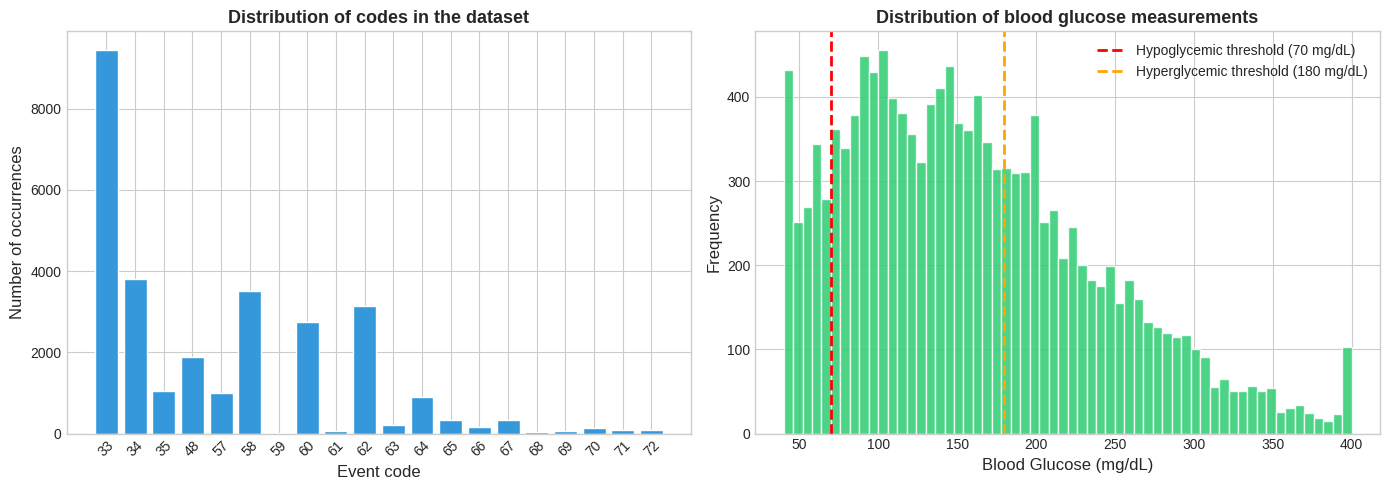


Blood glucose statistics:
count    13474.0
mean       160.1
std         79.6
min         40.0
25%         97.0
50%        149.0
75%        209.0
max        400.0
Name: value, dtype: float64

Values < 70 mg/dL (hypoglycemia from blood glucose): 1575 (11.7%)


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

code_counts = df_clean['code'].value_counts().sort_index()
bars = axes[0].bar(
    code_counts.index.astype(str),
    code_counts.values,
    color='#3498db', edgecolor='white'
)
axes[0].set_xlabel('Event code', fontsize=12)
axes[0].set_ylabel('Number of occurrences', fontsize=12)
axes[0].set_title('Distribution of codes in the dataset', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

bg_df = df_clean[df_clean['code'].isin(BG_CODES)]['value'].dropna()
bg_df = bg_df[(bg_df >= 40) & (bg_df <= 400)]
axes[1].hist(bg_df, bins=60, color='#2ecc71', edgecolor='white', alpha=0.85)
axes[1].axvline(70, color='red', linestyle='--', linewidth=2, label='Hypoglycemic threshold (70 mg/dL)')
axes[1].axvline(180, color='orange', linestyle='--', linewidth=2, label='Hyperglycemic threshold (180 mg/dL)')
axes[1].set_xlabel('Blood Glucose (mg/dL)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of blood glucose measurements', fontsize=13, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('fig1_exploratory.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nBlood glucose statistics:')
print(bg_df.describe().round(1))
print(f'\nValues < 70 mg/dL (hypoglycemia from blood glucose): {(bg_df < 70).sum()} ({(bg_df < 70).mean()*100:.1f}%)')

**Key observations:**

- The most frequent events are **insulin doses (code 33)** and **pre-meal glucose 
  measurements (codes 58–63)**, reflecting the typical daily routine of an 
  insulin-dependent patient.
- **Hypoglycemic symptoms (code 65)** are rare — fewer than 500 occurrences across 
  all 70 patients. Note that this code reflects *self-reported symptoms* by the patient 
  and is **not used as our target variable**. Our target is instead derived objectively 
  from blood glucose measurements falling below 70 mg/dL.
- The blood glucose distribution is **right-skewed**, with a mean of ~160 mg/dL, 
  consistent with a population of patients with suboptimal glycemic control.
- **11.7% of glucose measurements** fall below 70 mg/dL, which will translate into 
  a moderately imbalanced classification problem.

### 4.2 Feature Engineering & Windowing

To transform longitudinal patient records into a format suitable for classification, 
we adopt a **sliding window over the last N glucose measurements** rather than a 
fixed time window. Given the high irregularity of the data (mean gap ~7 hours between 
measurements), a time-based window would be unreliable and often empty.

For each glucose measurement, we look back at the previous **N = 5 readings** and 
extract the following features:

**Glucose dynamics**

| Feature | Description |
|---------|-------------|
| `bg_last` | Most recent glucose value |
| `bg_mean` | Average over the last N readings: captures the overall level |
| `bg_min` | Minimum value in the window: captures whether the patient already touched dangerous levels |
| `bg_std` | Standard deviation: captures glycemic variability |
| `bg_trend` | Difference between last and first reading: indicates whether glucose is rising or falling |
| `bg_below_80` | Number of readings below 80 mg/dL: counts how many times the patient was already in the risk zone |

**Insulin**

| Feature | Description |
|---------|-------------|
| `total_insulin` | Total insulin administered during the window (all types combined) |
| `window_hours` | Duration of the window in hours: provides temporal context for the insulin sum |

**Behavioral context**

| Feature | Description |
|---------|-------------|
| `had_small_meal` | Whether a smaller-than-usual meal was recorded (code 68)|
| `any_meal` | Whether any meal was recorded |
| `had_intense_exercise` | Whether intense physical activity was recorded (code 70) |

**Temporal**

| Feature | Description |
|---------|-------------|
| `time_slot` | Time of day: 0 = night (0–6h), 1 = morning (6–12h), 2 = afternoon (12–18h), 3 = evening (18–24h) |

**Target definition**

A sample is labeled as positive (`1`) if **at least one of the next M = 2 glucose 
measurements falls below 70 mg/dL**. Using the next 2 readings rather than just 1 
makes the target more robust to isolated noisy measurements, while still remaining 
a short-term prediction.

In [21]:
N_LOOKBACK = 5
M_NEXT     = 2

def extract_features(patient_df, bg_history, ref_time):
    bg_vals      = bg_history['value']
    window_start = bg_history['datetime'].iloc[0]
    window_hours = (ref_time - window_start).total_seconds() / 3600

    features = {}

    features['bg_last']     = bg_vals.iloc[-1]
    features['bg_mean']     = bg_vals.mean()
    features['bg_min']      = bg_vals.min()
    features['bg_std']      = bg_vals.std() if len(bg_vals) > 1 else 0.0
    features['bg_trend']    = bg_vals.iloc[-1] - bg_vals.iloc[0]
    features['bg_below_80'] = int((bg_vals < 80).sum())

    ins = patient_df[
        (patient_df['datetime'] >= window_start) &
        (patient_df['datetime'] <= ref_time) &
        (patient_df['code'].isin([33, 34, 35]))
    ]
    features['total_insulin'] = ins['value'].sum()
    features['window_hours']  = round(window_hours, 1)

    meals = patient_df[
        (patient_df['datetime'] >= window_start) &
        (patient_df['datetime'] <= ref_time) &
        (patient_df['code'].isin([66, 67, 68]))
    ]
    features['had_small_meal'] = int((meals['code'] == 68).any())
    features['any_meal']       = int(len(meals) > 0)

    exer = patient_df[
        (patient_df['datetime'] >= window_start) &
        (patient_df['datetime'] <= ref_time) &
        (patient_df['code'].isin([69, 70, 71]))
    ]
    features['had_intense_exercise'] = int((exer['code'] == 70).any())

    features['time_slot'] = (
        0 if ref_time.hour < 6  else
        1 if ref_time.hour < 12 else
        2 if ref_time.hour < 18 else 3
    )

    return features


def build_dataset(df_clean, n_lookback=N_LOOKBACK, m_next=M_NEXT):
    records = []
    for pid, patient_df in df_clean.groupby('patient_id'):
        patient_df = patient_df.sort_values('datetime').reset_index(drop=True)
        all_bg = (patient_df[patient_df['code'].isin(BG_CODES)]
                  .dropna(subset=['value'])
                  .reset_index(drop=True))

        for i in range(n_lookback - 1, len(all_bg) - m_next):
            bg_history = all_bg.iloc[i - n_lookback + 1 : i + 1]
            ref_time   = all_bg.iloc[i]['datetime']
            next_bgs   = all_bg.iloc[i + 1 : i + 1 + m_next]
            label      = int((next_bgs['value'] < 70).any())

            feats               = extract_features(patient_df, bg_history, ref_time)
            feats['label']      = label
            feats['patient_id'] = pid
            records.append(feats)

    return pd.DataFrame(records).reset_index(drop=True)


dataset = build_dataset(df_clean)

n_pos = dataset['label'].sum()
n_neg = (dataset['label'] == 0).sum()
print(f'Total samples    : {len(dataset):,}')
print(f'  Positive (hypo): {n_pos:,}  ({100*n_pos/len(dataset):.1f}%)')
print(f'  Negative       : {n_neg:,}  ({100*n_neg/len(dataset):.1f}%)')


Total samples    : 13,060
  Positive (hypo): 2,797  (21.4%)
  Negative       : 10,263  (78.6%)


In [22]:
META_COLS    = ['label', 'patient_id']
FEATURE_COLS = [c for c in dataset.columns if c not in META_COLS]

assert 'label'      not in FEATURE_COLS
assert 'patient_id' not in FEATURE_COLS

print(f'Selected features ({len(FEATURE_COLS)}):')
for f in FEATURE_COLS:
    print(f'   - {f}')

Selected features (12):
   - bg_last
   - bg_mean
   - bg_min
   - bg_std
   - bg_trend
   - bg_below_80
   - total_insulin
   - window_hours
   - had_small_meal
   - any_meal
   - had_intense_exercise
   - time_slot


### 4.3 Class Distribution

The two plots below characterize the **prediction dataset**, the table of samples 
produced by the sliding window procedure.

The **left plot** shows the proportion of positive and negative samples. With 21.4% 
positive cases, the dataset is moderately imbalanced: hypoglycemic events are the 
minority class. This is clinically expected, hypoglycemia is a relatively rare event 
in the daily life of a diabetic patient, even in a high-risk population.

The **right plot** shows the distribution of `bg_last` (the most recent glucose 
measurement) separately for the two classes. Two observations are worth noting:

- Hypoglycemic samples (red) are concentrated at **lower glucose values**, as expected.
  A patient already close to 70 mg/dL is naturally at higher risk in the near future.
- However, a substantial portion of hypoglycemic events occurs at **glucose values well 
  above 70 mg/dL** at the time of prediction. This confirms that the problem is 
  non-trivial: the current glucose level alone is not sufficient to predict future 
  hypoglycemia, and the additional features (trend, insulin, meals, exercise) 
  carry meaningful predictive information.

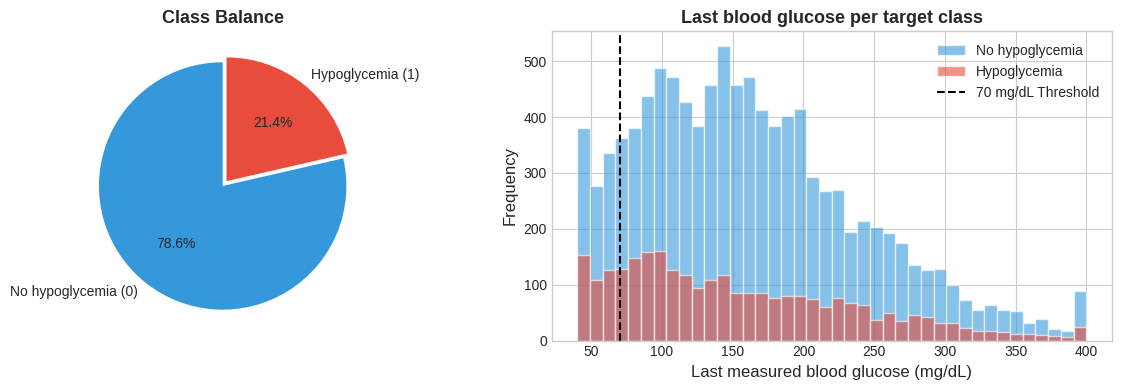

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

label_counts = dataset['label'].value_counts()
axes[0].pie(
    label_counts.values,
    labels=['No hypoglycemia (0)', 'Hypoglycemia (1)'],
    autopct='%1.1f%%',
    colors=['#3498db', '#e74c3c'],
    startangle=90,
    explode=[0, 0.05]
)
axes[0].set_title('Class Balance', fontsize=13, fontweight='bold')

for label, color, name in [(0, '#3498db', 'No hypoglycemia'), (1, '#e74c3c', 'Hypoglycemia')]:
    vals = dataset[dataset['label'] == label]['bg_last'].dropna()
    axes[1].hist(vals, bins=40, alpha=0.6, color=color, label=name, edgecolor='white')
axes[1].axvline(70, color='black', linestyle='--', linewidth=1.5, label='70 mg/dL Threshold')
axes[1].set_xlabel('Last measured blood glucose (mg/dL)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Last blood glucose per target class', fontsize=13, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('fig2_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Methodology – Machine Learning Algorithms

### What is binary classification?

A classification model learns from historical data (labeled examples) to predict 
which **category** a new example belongs to. In our case: hypoglycemia (`1`) or 
no hypoglycemia (`0`).

### Algorithms Used

| Algorithm | Description |
|-----------|-------------|
| **Logistic Regression** | A linear model that estimates the probability of belonging to a class based on a weighted combination of the input features. Simple, fast, and highly interpretable: the weight of each feature directly indicates its direction and magnitude of effect. |
| **Random Forest** | An ensemble of many decision trees, each trained on a random subset of the data, whose predictions are averaged. Robust to outliers and capable of capturing non-linear relationships between features. |

These two models were chosen deliberately: Logistic Regression represents the 
**simplest interpretable baseline**, while Random Forest represents a more 
**flexible non-linear approach**. Comparing them allows us to assess whether 
the problem requires complexity beyond a linear model.

### Train / Test Split

The dataset is split into a **training set (80%)** and a **test set (20%)**, 
where the split is performed **at the patient level**: all records from a given 
patient appear in either train or test, never in both. This is essential to avoid 
data leakage. A model evaluated on records from patients it has already seen 
during training would produce artificially optimistic results.

### Cross-Validation

Within the training set, we use **Stratified Group K-Fold Cross-Validation** (k=5) 
to tune and compare models. At each fold, the model is trained on 4 groups of 
patients and validated on the fifth. Stratification ensures that the proportion 
of positive cases is approximately balanced across folds.

### Handling Class Imbalance

Since hypoglycemic events represent only ~21% of samples, a naive model could 
achieve high accuracy by always predicting "no hypoglycemia." To address this, 
we use the `class_weight='balanced'` parameter, which automatically increases 
the penalty for misclassifying the minority class during training.

In [9]:
patient_has_hypo = (
    dataset.groupby('patient_id')['label']
    .max()
    .reset_index()
    .rename(columns={'label': 'has_hypo'})
)

train_pids, test_pids = train_test_split(
    patient_has_hypo['patient_id'],
    test_size=0.2,
    stratify=patient_has_hypo['has_hypo'],
    random_state=RANDOM_STATE
)
train_mask = dataset['patient_id'].isin(train_pids)
test_mask = dataset['patient_id'].isin(test_pids)

X_train = dataset.loc[train_mask, FEATURE_COLS].copy()
y_train = dataset.loc[train_mask, 'label'].copy()
groups_train = dataset.loc[train_mask, 'patient_id'].copy()

X_test = dataset.loc[test_mask, FEATURE_COLS].copy()
y_test = dataset.loc[test_mask, 'label'].copy()
assert len(set(train_pids) & set(test_pids)) == 0, "Data leakage: patient in train and test!"
print(f'Training set: {len(X_train):,} examples ({len(train_pids)} patients)')
print(f'Test set:     {len(X_test):,} examples ({len(test_pids)} patients)')
print(f'\nPositive proportion – Train: {y_train.mean()*100:.1f}% | Test: {y_test.mean()*100:.1f}%')


Training set: 10,452 examples (55 patients)
Test set:     2,608 examples (14 patients)

Positive proportion – Train: 22.2% | Test: 18.1%


In [11]:
models = {
    'Logistic Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  StandardScaler()),
        ('clf',     LogisticRegression(
                        class_weight='balanced',
                        max_iter=1000,
                        random_state=RANDOM_STATE
                    ))
    ]),

    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('clf',     RandomForestClassifier(
                        n_estimators=200,
                        max_depth=10,
                        min_samples_leaf=5,
                        class_weight='balanced',
                        random_state=RANDOM_STATE
                    ))
    ]),
}

In [12]:
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_results = {}

for name, pipeline in models.items():
    print(f'  Training: {name}...')
    scores = cross_validate(
        pipeline, X_train, y_train,
        groups=groups_train,
        cv=cv,
        scoring=['roc_auc', 'average_precision', 'f1', 'precision', 'recall'],
        n_jobs=-1,
        return_train_score=False
    )
    cv_results[name] = scores

  Training: Logistic Regression...
  Training: Random Forest...


### Evaluation Metrics

Given the clinical context, we evaluate models using the following metrics:

| Metric | Description | Why it matters here |
|--------|-------------|---------------------|
| **ROC-AUC** | Area under the ROC curve — overall ability to rank positive cases higher than negative ones | Primary comparison metric, threshold-independent |
| **Recall (Sensitivity)** | Fraction of real hypoglycemic events correctly detected | Missing an event is clinically dangerous |
| **Precision (PPV)** | Fraction of predicted events that are real | Too many false alarms reduce patient trust |
| **F1-Score** | Harmonic mean of Precision and Recall | Balances the two competing objectives |
| **Average Precision** | Area under the Precision-Recall curve — more informative than ROC-AUC on imbalanced data | Directly reflects performance on the minority class |

> In a clinical alert system, **Recall is the priority**: it is safer to trigger 
> a false alarm (the patient eats a snack unnecessarily) than to miss a real 
> hypoglycemic event (the patient loses consciousness).

In [13]:
for name, scores in cv_results.items():
    print(f'\n{name}')
    for metric in ['roc_auc', 'average_precision', 'recall', 'precision', 'f1']:
        m = scores[f'test_{metric}'].mean()
        s = scores[f'test_{metric}'].std()
        print(f'  {metric:<20}: {m:.3f} ± {s:.3f}')


Logistic Regression
  roc_auc             : 0.666 ± 0.014
  average_precision   : 0.350 ± 0.018
  recall              : 0.631 ± 0.014
  precision           : 0.315 ± 0.006
  f1                  : 0.420 ± 0.004

Random Forest
  roc_auc             : 0.697 ± 0.022
  average_precision   : 0.429 ± 0.056
  recall              : 0.500 ± 0.065
  precision           : 0.380 ± 0.035
  f1                  : 0.432 ± 0.046


### Cross-Validation Results — Interpretation

Both models perform above the random baseline (ROC-AUC = 0.5), confirming that 
the features extracted from recent glucose measurements carry genuine predictive 
signal.

**Logistic Regression** achieves the highest Recall (0.631), meaning it detects 
nearly two thirds of future hypoglycemic events. However, its Precision is low 
(0.315): roughly one in three alerts would correspond to a real event.

**Random Forest** offers a better balance: slightly higher ROC-AUC (0.697) and 
Precision (0.380), at the cost of lower Recall (0.500). It is a more conservative 
model: it raises fewer alarms, but a higher fraction of them are justified.

The higher standard deviation of Random Forest across folds 
reflects the genuine heterogeneity between patients: what works well for some 
patients may not generalize to others. With only 70 patients, this variability 
is expected and should be interpreted as a property of the data, not a flaw 
of the model.

**Model selection:** We proceed with **Random Forest** as the primary model, 
given its better overall ROC-AUC and Precision-Recall tradeoff. The final 
evaluation on the held-out test set follows.

## 6. Results & Discussion

### 6.1 Cross-Validation Results

In [14]:
summary_rows = []
for name, scores in cv_results.items():
    summary_rows.append({
        'Model': name,
        'ROC-AUC (mean ± std)': f'{scores["test_roc_auc"].mean():.3f} ± {scores["test_roc_auc"].std():.3f}',
        'F1 (mean ± std)':      f'{scores["test_f1"].mean():.3f} ± {scores["test_f1"].std():.3f}',
        'Precision (mean)':     f'{scores["test_precision"].mean():.3f}',
        'Recall/Sensitivity (mean)': f'{scores["test_recall"].mean():.3f}',
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

=== CROSS-VALIDATION RESULTS (5-Fold) ===


,Model,ROC-AUC (mean ± std),F1 (mean ± std),Precision (mean),Recall/Sensitivity (mean)
0,Logistic Regression,0.666 ± 0.014,0.420 ± 0.004,0.315,0.631
1,Random Forest,0.697 ± 0.022,0.432 ± 0.046,0.380,0.500


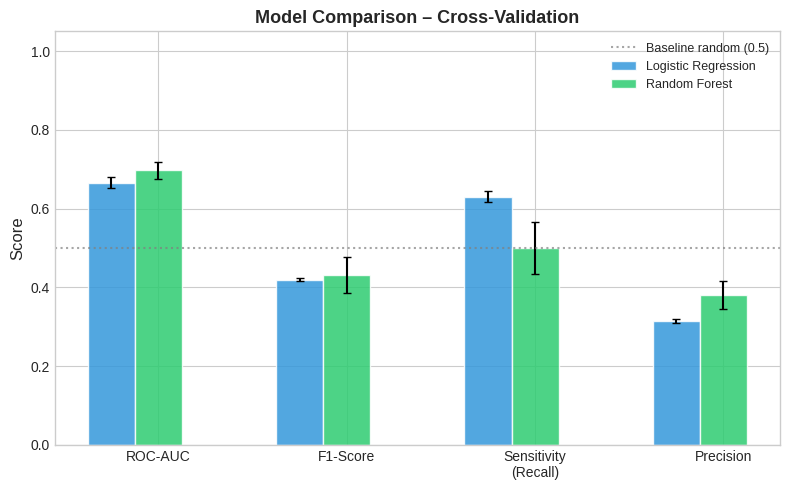

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

metrics_to_plot = ['test_roc_auc', 'test_f1', 'test_recall', 'test_precision']
metric_labels   = ['ROC-AUC', 'F1-Score', 'Sensitivity\n(Recall)', 'Precision']
colors_models   = ['#3498db', '#2ecc71', '#e74c3c']

x     = np.arange(len(metric_labels))
width = 0.25

for i, (name, scores) in enumerate(cv_results.items()):
    means = [scores[m].mean() for m in metrics_to_plot]
    stds  = [scores[m].std()  for m in metrics_to_plot]
    ax.bar(
        x + i * width, means, width,
        label=name, color=colors_models[i], alpha=0.85,
        yerr=stds, capsize=3, edgecolor='white'
    )

ax.set_xticks(x + width)
ax.set_xticklabels(metric_labels, fontsize=10)
ax.set_ylim(0, 1.05)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Comparison – Cross-Validation', fontsize=13, fontweight='bold')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.7, label='Baseline random (0.5)')
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('fig3_cv_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

The cross-validation results confirm that both models learn meaningful patterns 
from the data. Random Forest achieves a slightly better ROC-AUC (0.697 vs 0.666) 
and Precision, while Logistic Regression achieves higher Recall. We proceed with 
**Random Forest** as the primary model for final evaluation.

In [16]:
test_results = {}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred       = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    test_results[name] = {
        'y_pred':       y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc':      roc_auc_score(y_test, y_pred_proba),
        'report':       classification_report(y_test, y_pred,
                            target_names=['No Hypoglycemia', 'Hypoglycemia'])
    }

for name, res in test_results.items():
    print(f'\n=== {name} — TEST SET ===')
    print(f'ROC-AUC: {res["roc_auc"]:.3f}')
    print(res['report'])


=== Logistic Regression — TEST SET ===
ROC-AUC: 0.628
                 precision    recall  f1-score   support

No Hypoglycemia       0.87      0.65      0.75      2135
   Hypoglycemia       0.26      0.55      0.35       473

       accuracy                           0.64      2608
      macro avg       0.56      0.60      0.55      2608
   weighted avg       0.76      0.64      0.67      2608


=== Random Forest — TEST SET ===
ROC-AUC: 0.673
                 precision    recall  f1-score   support

No Hypoglycemia       0.87      0.74      0.80      2135
   Hypoglycemia       0.30      0.49      0.37       473

       accuracy                           0.70      2608
      macro avg       0.58      0.62      0.58      2608
   weighted avg       0.76      0.70      0.72      2608



### 6.2 Test Set Evaluation

The plots below show the performance of both models on the **held-out test set**.

**How to read the confusion matrix:**
- **Top-left (TN):** correctly predicted "no hypoglycemia"
- **Bottom-right (TP):** hypoglycemic events correctly detected → clinical priority
- **Bottom-left (FN):** missed hypoglycemic events → most dangerous error
- **Top-right (FP):** false alarms → annoying but not dangerous

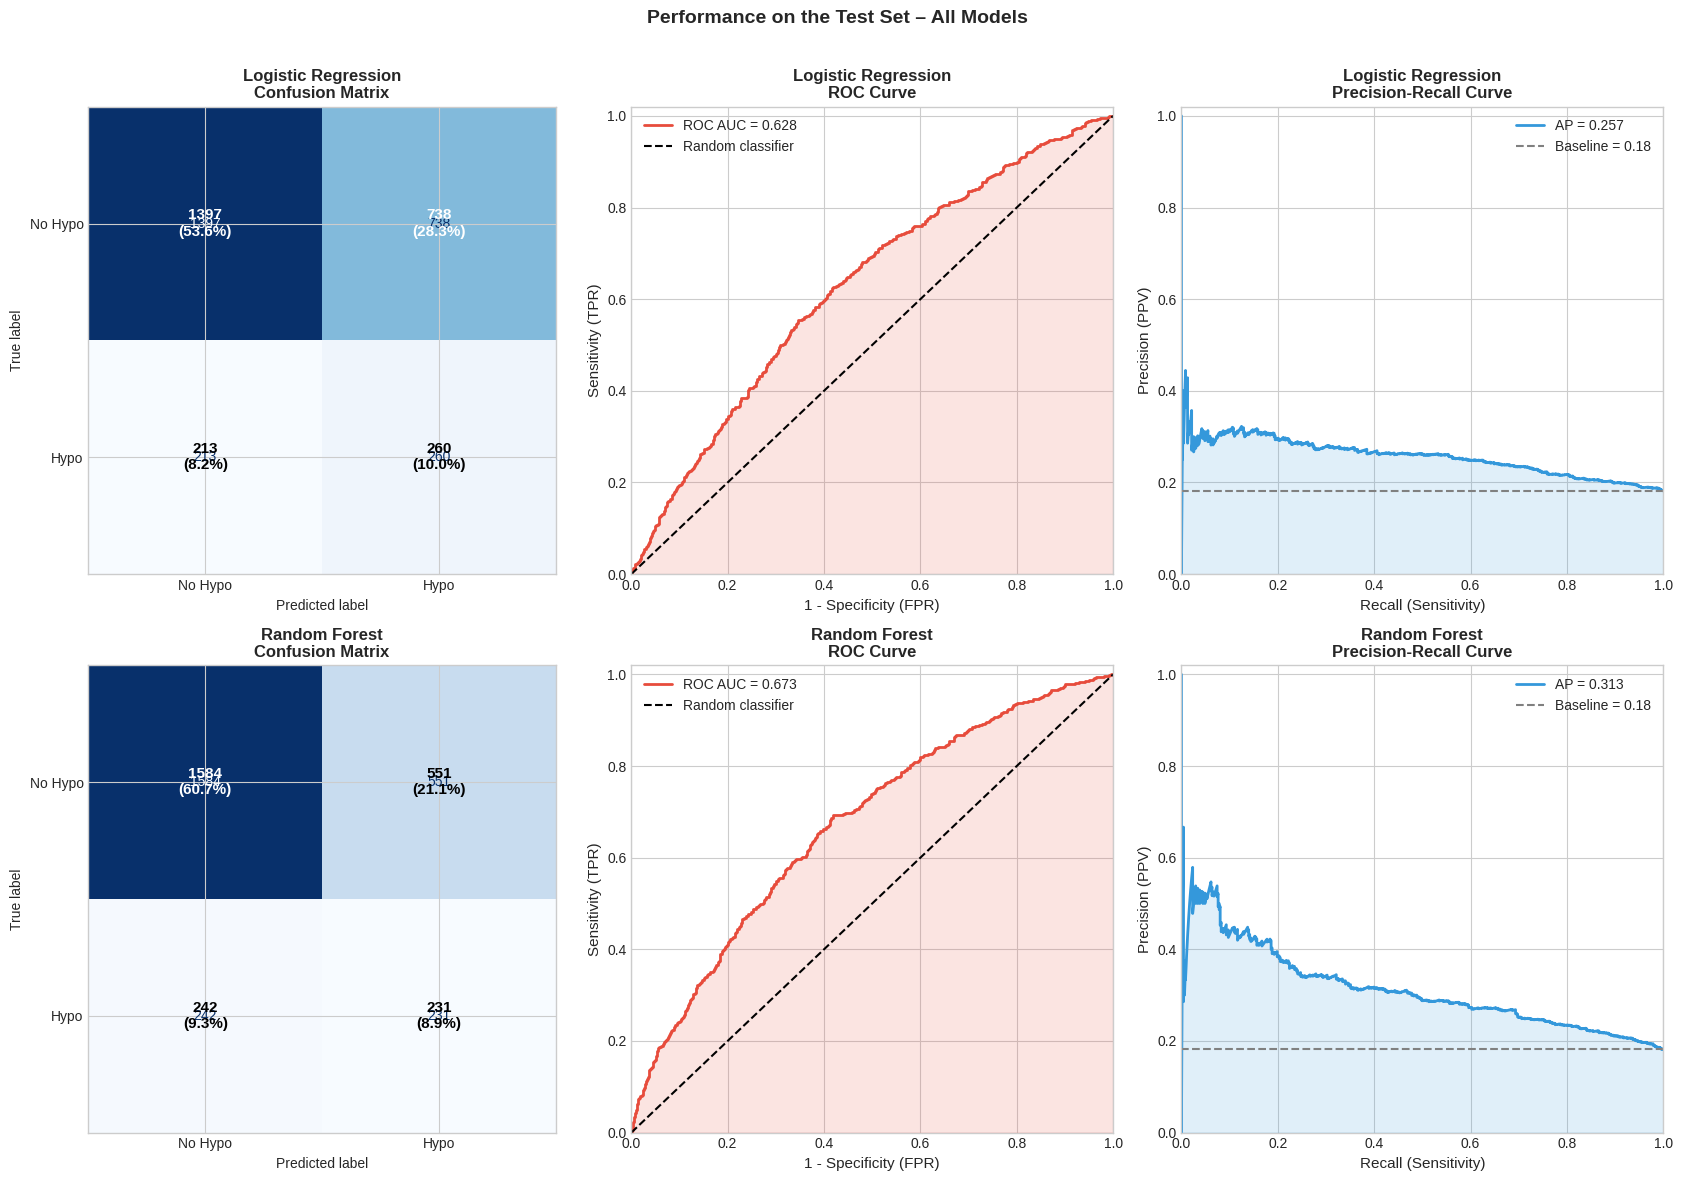

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(17, 12))

for row, (name, res) in enumerate(test_results.items()):
    y_pred       = res['y_pred']
    y_pred_proba = res['y_pred_proba']

    cm   = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=['No Hypo', 'Hypo'])
    disp.plot(ax=axes[row, 0], colorbar=False, cmap='Blues', values_format='')
    total = cm.sum()
    for (i, j), val in np.ndenumerate(cm):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        axes[row, 0].text(j, i, f'{val}\n({val/total*100:.1f}%)',
                     ha='center', va='center', fontsize=11,
                     color=color, fontweight='bold')
    axes[row, 0].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_val     = roc_auc_score(y_test, y_pred_proba)
    axes[row, 1].plot(fpr, tpr, color='#e74c3c', lw=2, label=f'ROC AUC = {auc_val:.3f}')
    axes[row, 1].plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random classifier')
    axes[row, 1].fill_between(fpr, tpr, alpha=0.15, color='#e74c3c')
    axes[row, 1].set_xlabel('1 - Specificity (FPR)', fontsize=11)
    axes[row, 1].set_ylabel('Sensitivity (TPR)', fontsize=11)
    axes[row, 1].set_title(f'{name}\nROC Curve', fontsize=12, fontweight='bold')
    axes[row, 1].legend(fontsize=10)
    axes[row, 1].set_xlim([0, 1]); axes[row, 1].set_ylim([0, 1.02])

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    ap = average_precision_score(y_test, y_pred_proba)
    axes[row, 2].plot(recall_curve, precision_curve, color='#3498db', lw=2, label=f'AP = {ap:.3f}')
    axes[row, 2].fill_between(recall_curve, precision_curve, alpha=0.15, color='#3498db')
    baseline_prec = y_test.mean()
    axes[row, 2].axhline(baseline_prec, color='gray', linestyle='--', lw=1.5,
                    label=f'Baseline = {baseline_prec:.2f}')
    axes[row, 2].set_xlabel('Recall (Sensitivity)', fontsize=11)
    axes[row, 2].set_ylabel('Precision (PPV)', fontsize=11)
    axes[row, 2].set_title(f'{name}\nPrecision-Recall Curve', fontsize=12, fontweight='bold')
    axes[row, 2].legend(fontsize=10)
    axes[row, 2].set_xlim([0, 1]); axes[row, 2].set_ylim([0, 1.02])

plt.suptitle('Performance on the Test Set – All Models',
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('fig4_performance.png', dpi=150, bbox_inches='tight')
plt.show()

**Logistic Regression** detects 55% of hypoglycemic events (TP = 260) but raises 
a large number of false alarms (FP = 738) — 1 in 4 alerts corresponds to a real event. 
ROC-AUC = 0.628.

**Random Forest** is more conservative: it detects fewer events (TP = 231, Recall = 49%) 
but with better Precision (30%) and fewer false alarms (FP = 551). ROC-AUC = 0.673.

Both models perform above the random baseline. The gap between cross-validation 
and test set performance is expected with only 70 patients — small variations in 
patient composition between folds produce visible differences in metrics.

### 6.3 Feature Importance & Model Interpretability

Inspecting which features drive the predictions is essential in a clinical context.

**Logistic Regression — Coefficients**

The sign of each coefficient indicates direction (red = increases risk, 
blue = decreases risk). Because features are standardized, magnitudes are 
directly comparable.

The top 5 features by absolute magnitude are:

| Feature | Coefficient | Interpretation |
|---------|-------------|----------------|
| `bg_min` | −0.244 | The lower the minimum glucose in the window, the higher the risk — the patient has already been close to dangerous levels |
| `bg_mean` | −0.222 | A lower average glucose over recent measurements increases risk |
| `bg_last` | +0.212 | Counterintuitively positive: a higher *current* reading may reflect post-meal hyperglycemia followed by a rapid drop |
| `bg_below_80` | +0.193 | More readings already in the risk zone → higher future risk |
| `total_insulin` | −0.192 | Higher insulin in the window is associated with lower future glucose — direct pharmacological effect |

The negative sign of `bg_min` and `bg_mean` is clinically intuitive: a patient 
whose recent glucose has been consistently low is more likely to drop further. 
The positive sign of `bg_last` is the most interesting finding: it suggests 
that a high current reading does not protect against future hypoglycemia if the 
preceding values were low, capturing the dynamics of post-insulin glucose crashes.

**Random Forest — Feature Importance**

Random Forest confirms that glucose-level features dominate, but with a different 
ranking:

| Rank | Feature | Importance |
|------|---------|------------|
| 1 | `bg_min` | 0.172 |
| 2 | `total_insulin` | 0.143 |
| 3 | `bg_std` | 0.138 |
| 4 | `bg_mean` | 0.124 |
| 5 | `window_hours` | 0.103 |

The prominence of `total_insulin` (rank 2) and `bg_std` (rank 3) is noteworthy. 
High insulin combined with high glycemic variability is a well-known risk factor 
for hypoglycemia — the model has learned this pattern from data alone, without 
being explicitly programmed with clinical rules. The appearance of `window_hours` 
in the top 5 reflects the importance of temporal context: the same insulin dose 
carries different risk depending on how long ago it was administered.

Behavioral features (`had_small_meal`, `had_intense_exercise`) rank lower in both 
models, likely because they are recorded infrequently in this dataset: their 
clinical relevance is real, but the signal is sparse.

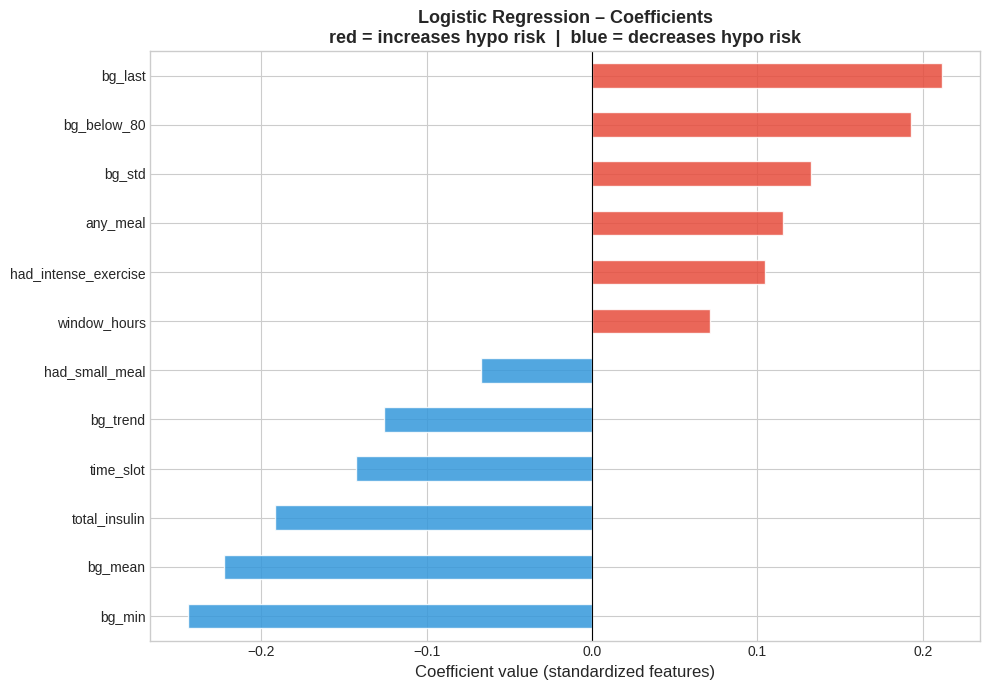


Top 5 features (Logistic Regression):
  1. bg_min: -0.2441
  2. bg_mean: -0.2224
  3. bg_last: +0.2117
  4. bg_below_80: +0.1929
  5. total_insulin: -0.1917


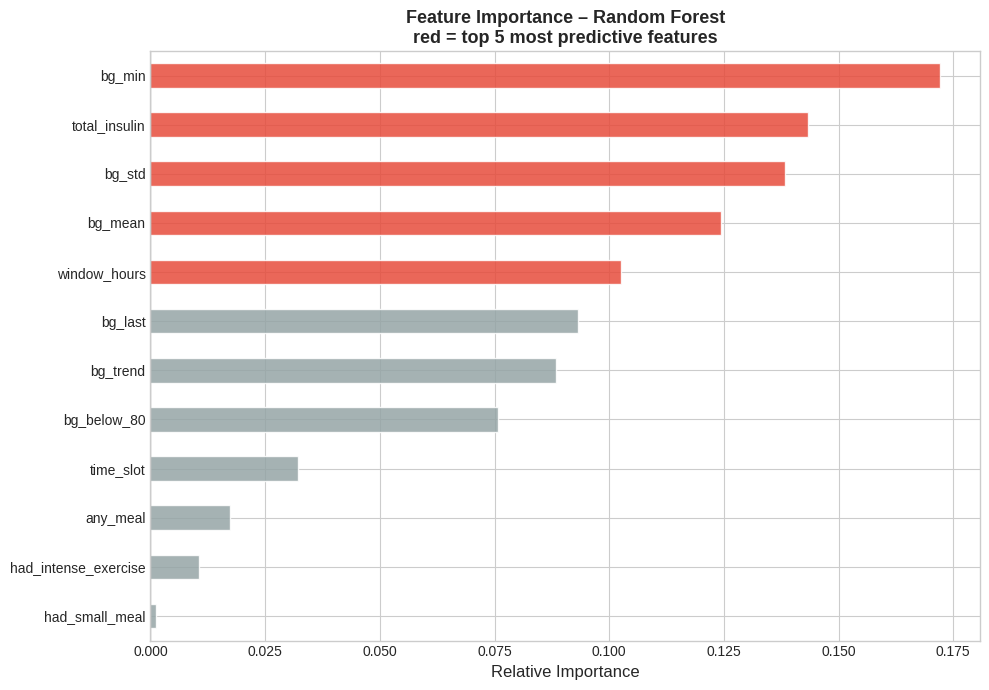


Top 5 features (Random Forest):
  1. bg_min: +0.1722
  2. total_insulin: +0.1433
  3. bg_std: +0.1384
  4. bg_mean: +0.1244
  5. window_hours: +0.1025


In [19]:
for name, pipeline in models.items():
    clf_step = pipeline.named_steps['clf']
    fig, ax  = plt.subplots(figsize=(10, 7))

    if hasattr(clf_step, 'feature_importances_'):
        raw    = pd.Series(clf_step.feature_importances_, index=FEATURE_COLS)
        values = raw.sort_values(ascending=True)
        top5   = set(raw.nlargest(5).index)
        colors = ['#e74c3c' if f in top5 else '#95a5a6' for f in values.index]
        xlabel = 'Relative Importance'
        title  = (f'Feature Importance – {name}\n'
                  'red = top 5 most predictive features')
        ax.axvline(0, color='black', linewidth=0.8)
    else:
        raw    = pd.Series(clf_step.coef_[0], index=FEATURE_COLS)
        values = raw.sort_values(ascending=True)
        top5   = set(raw.abs().nlargest(5).index)
        colors = ['#e74c3c' if v > 0 else '#3498db' for v in values]
        xlabel = 'Coefficient value (standardized features)'
        title  = (f'Logistic Regression – Coefficients\n'
                  'red = increases hypo risk  |  blue = decreases hypo risk')
        ax.axvline(0, color='black', linewidth=0.8)

    values.plot(kind='barh', ax=ax, color=colors, edgecolor='white', alpha=0.85)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'fig5_interpretability_{name.lower().replace(" ", "_")}.png',
                dpi=150, bbox_inches='tight')
    plt.show()

    # Top 5 in console
    print(f'\nTop 5 features ({name}):')
    for i, (feat, val) in enumerate(raw.abs().nlargest(5).items(), 1):
        sign = '+' if raw[feat] > 0 else '-'
        print(f'  {i}. {feat}: {sign}{abs(val):.4f}')

### 6.4 Decision Threshold Analysis

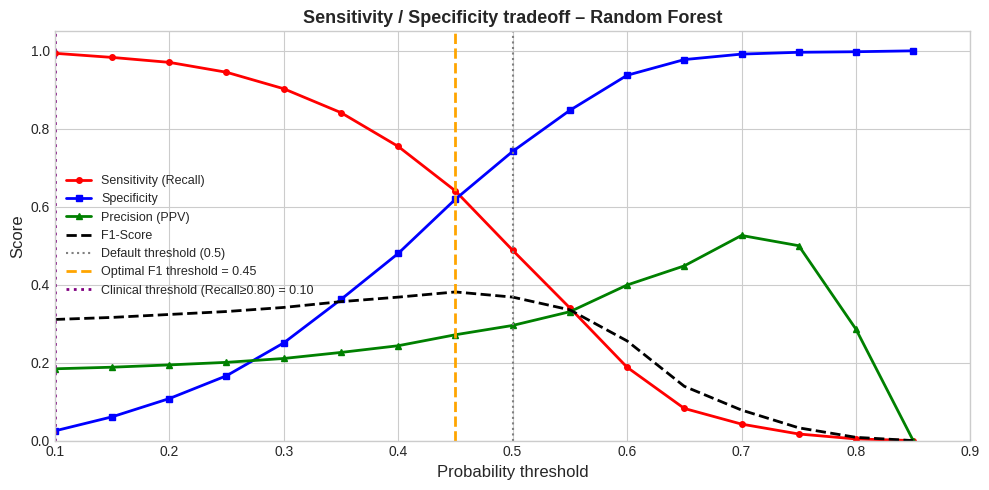


Optimal F1 threshold : 0.45
  Sensitivity : 0.641
  Specificity : 0.619
  Precision   : 0.272
  → Out of 100 alerts, ~27 correspond to real events
  → Out of 100 real events, ~64 are detected

Clinical threshold (Recall≥0.80) : 0.10
  Sensitivity : 0.994
  Specificity : 0.025
  Precision   : 0.184


In [24]:
CHOSEN_MODEL  = 'Random Forest'
y_pred_proba  = test_results[CHOSEN_MODEL]['y_pred_proba']

thresholds = np.arange(0.1, 0.9, 0.05)
sens_list, spec_list, f1_list, ppv_list = [], [], [], []

for thr in thresholds:
    y_thr = (y_pred_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_thr).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv  = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1   = 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else 0
    sens_list.append(sens); spec_list.append(spec)
    ppv_list.append(ppv);   f1_list.append(f1)

best_thr_idx = np.argmax(f1_list)
best_thr     = thresholds[best_thr_idx]
clinical_idx = next((i for i, s in enumerate(sens_list) if s >= 0.80), None)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, sens_list, 'r-o', markersize=4, label='Sensitivity (Recall)', linewidth=2)
ax.plot(thresholds, spec_list, 'b-s', markersize=4, label='Specificity',          linewidth=2)
ax.plot(thresholds, ppv_list,  'g-^', markersize=4, label='Precision (PPV)',       linewidth=2)
ax.plot(thresholds, f1_list,   'k--', markersize=4, label='F1-Score',              linewidth=2)

ax.axvline(0.5,      color='gray',   linestyle=':',  lw=1.5, label='Default threshold (0.5)')
ax.axvline(best_thr, color='orange', linestyle='--', lw=2,
           label=f'Optimal F1 threshold = {best_thr:.2f}')
if clinical_idx is not None:
    clinical_thr = thresholds[clinical_idx]
    ax.axvline(clinical_thr, color='purple', linestyle=':', lw=2,
               label=f'Clinical threshold (Recall≥0.80) = {clinical_thr:.2f}')

ax.set_xlabel('Probability threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Sensitivity / Specificity tradeoff – {CHOSEN_MODEL}',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.set_xlim([0.1, 0.9]); ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.savefig('fig6_threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nOptimal F1 threshold : {best_thr:.2f}')
print(f'  Sensitivity : {sens_list[best_thr_idx]:.3f}')
print(f'  Specificity : {spec_list[best_thr_idx]:.3f}')
print(f'  Precision   : {ppv_list[best_thr_idx]:.3f}')
print(f'  → Out of 100 alerts, ~{ppv_list[best_thr_idx]*100:.0f} correspond to real events')
print(f'  → Out of 100 real events, ~{sens_list[best_thr_idx]*100:.0f} are detected')

if clinical_idx is not None:
    print(f'\nClinical threshold (Recall≥0.80) : {clinical_thr:.2f}')
    print(f'  Sensitivity : {sens_list[clinical_idx]:.3f}')
    print(f'  Specificity : {spec_list[clinical_idx]:.3f}')
    print(f'  Precision   : {ppv_list[clinical_idx]:.3f}')

By default, a classifier predicts hypoglycemia when the estimated probability 
exceeds **0.5**. However, this threshold is arbitrary and can be adjusted 
depending on the clinical objective.

The plot above shows how Sensitivity, Specificity, and Precision change as the 
threshold varies for the Random Forest model.

**Optimal F1 threshold (0.45):**  
Sensitivity = 0.641, Specificity = 0.619, Precision = 0.272  
→ Out of 100 alerts, ~27 correspond to real events  
→ Out of 100 real events, ~64 are detected

**Clinical threshold (Recall ≥ 0.80, threshold = 0.10):**  
Sensitivity = 0.994, Specificity = 0.025, Precision = 0.184  
→ Nearly all events are detected, but almost every measurement triggers an alert

This illustrates a fundamental principle: **the choice of threshold is not a 
technical decision — it is a clinical one.** A physician must decide what 
balance between missed events and false alarms is acceptable for their patients.

## 7. Interpretation and Limitations

### 7.1 Interpretation of Results

The Random Forest model trained on real patient data achieved a **ROC-AUC of 0.673** 
on the held-out test set, detecting 49% of future hypoglycemic events with a 
Precision of 30%.

These results are **modest but honest**. Given the constraints of the dataset — 
70 patients, sparse measurements with a mean gap of ~7 hours, and data collected 
in the early 1990s — a model that learns any meaningful signal is already a 
meaningful result. The key finding is that **recent glucose levels, insulin doses, 
and glycemic variability carry genuine predictive information** about future 
hypoglycemic risk, even with simple tabular features.

### 7.2 Limitations

**Dataset limitations:**
- Only 70 patients from a single collection period (1991–1992) → low generalizability 
  to modern patients and insulin regimens
- Paper records have fictitious timestamps (08:00, 12:00, 18:00, 22:00) → degraded 
  temporal information for 14 patients
- No information on HbA1c, diet composition, comorbidities, or diabetes type
- Hypoglycemic events may be **under-reported**: only symptomatic events are recorded 
  (code 65), and our target itself relies on sparse glucose measurements

**Modeling limitations:**
- The window is defined by the **last N = 5 measurements**, not a fixed time horizon — 
  depending on the patient, this may cover 2 hours or 20 hours
- With 70 patients, cross-validation folds contain ~11 patients each → high variance 
  in performance estimates
- The model is validated on patients from the same dataset; **generalization to new 
  patients** in a different clinical setting is not guaranteed

**Clinical implications:**
- A **false negative** (missed hypoglycemic event) is clinically more serious than 
  a false positive → lower probability thresholds (e.g. 0.10–0.45) may be preferable 
  depending on the clinical context, accepting more false alarms to avoid missing events
- This model should not **replace** continuous glucose monitoring (CGM) but could 
  **complement** it as an early warning layer in settings where CGM is unavailable

In [23]:
CHOSEN_MODEL = 'Random Forest'
res = test_results[CHOSEN_MODEL]
y_pred_final = res['y_pred']
y_proba_final = res['y_pred_proba']

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
sensitivity  = tp / (tp + fn)
specificity  = tn / (tn + fp)
precision_sc = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_sc        = 2 * precision_sc * sensitivity / (precision_sc + sensitivity) if (precision_sc + sensitivity) > 0 else 0
auc_final    = roc_auc_score(y_test, y_proba_final)

print(f'\nModel selected   : {CHOSEN_MODEL}')
print(f'\nTest Set Performance:')
print(f'  ROC-AUC              : {auc_final:.3f}')
print(f'  Sensitivity (Recall) : {sensitivity:.3f}  → {sensitivity*100:.1f}% of real events detected')
print(f'  Specificity          : {specificity:.3f}  → {specificity*100:.1f}% of non-events correct')
print(f'  Precision (PPV)      : {precision_sc:.3f}  → {precision_sc*100:.1f}% of alerts are real')
print(f'  F1-Score             : {f1_sc:.3f}')

print(f'\nModeling choices:')
print(f'  • Lookback window : last N = {N_LOOKBACK} glucose measurements')
print(f'  • Target horizon  : next M = {M_NEXT} glucose measurements')
print(f'  • Features        : {len(FEATURE_COLS)} tabular features')
print(f'  • Imbalance       : handled via class_weight="balanced"')
print(f'  • Validation      : 5-Fold Stratified Group Cross-Validation')
print(f'  • Dataset         : 70 patients, UCI Diabetes (1991–1992)')


Model selected   : Random Forest

Test Set Performance:
  ROC-AUC              : 0.673
  Sensitivity (Recall) : 0.488  → 48.8% of real events detected
  Specificity          : 0.742  → 74.2% of non-events correct
  Precision (PPV)      : 0.295  → 29.5% of alerts are real
  F1-Score             : 0.368

Modeling choices:
  • Lookback window : last N = 5 glucose measurements
  • Target horizon  : next M = 2 glucose measurements
  • Features        : 12 tabular features
  • Imbalance       : handled via class_weight="balanced"
  • Validation      : 5-Fold Stratified Group Cross-Validation
  • Dataset         : 70 patients, UCI Diabetes (1991–1992)


## 8. Conclusions

In this project, we built a machine learning pipeline for the **early prediction 
of hypoglycemic events** in insulin-dependent diabetic patients, using real 
outpatient data collected in the early 1990s.

**What we did:**
1. Loaded and cleaned a dataset of 70 patients from the UCI ML Repository
2. Designed a sliding window over the last $N$ = 5 glucose measurements to handle 
   the irregular sampling of the data
3. Extracted clinically interpretable features: glucose dynamics, insulin doses, 
   meal size, physical activity, and time of day
4. Addressed class imbalance using `class_weight='balanced'`
5. Compared two classification algorithms (Logistic Regression and Random Forest) 
   with patient-level cross-validation to prevent data leakage
6. Analyzed model performance through ROC curves, confusion matrices, 
   Precision-Recall curves, and decision threshold analysis

**Main results:**

The Random Forest model achieved a ROC-AUC of 0.673 on the held-out test set, 
detecting 49% of future hypoglycemic events with a Precision of 30%. These results 
confirm that recent glucose levels, insulin doses, and glycemic variability carry 
genuine predictive signal.

The most important finding is not the absolute performance, but the **clinical 
reasoning embedded in the model**: lower minimum glucose, higher insulin doses, 
and greater glycemic variability consistently increase predicted hypoglycemia risk, 
in full agreement with established clinical knowledge.

**Key takeaway:**

Machine learning can offer useful predictive support in diabetology, but requires 
quality data in adequate quantity, prospective validation on new patients, and 
integration with clinical judgment. A predictive model is a tool to assist 
decision-making, not a replacement for it.

**Possible next steps:**
- Use data from modern continuous glucose monitors (CGM), which provide readings 
  every 5 minutes instead of every 7 hours
- Build patient-specific models to capture individual glycemic patterns
- Integrate additional contextual data: sleep quality, stress, physical activity 
  tracked continuously
- Prospective clinical validation in a controlled trial